# Heart Disease Bayesian Network Pipeline
- 数据预处理 + 连续变量离散化
- 结构学习：PC / HillClimbSearch / 自定义边
- 参数估计：MLE / Bayesian (BDeu)
- 推理：Variable Elimination & Clique Tree 示例


In [1]:
import math
from pathlib import Path
from types import SimpleNamespace
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from IPython.display import Image, display
from pgmpy.base import DAG
from pgmpy.estimators import (
    PC,
    HillClimbSearch,    
    BDeu,
    BayesianEstimator,
)
from pgmpy.inference import BeliefPropagation
from pgmpy.models import DiscreteBayesianNetwork


## Data preprocessing and discretization
- 读取 `processed.cleveland.data`，清理缺失值
- 连续特征：临床阈值分箱（默认）或分位数分箱
- 输出：原始 df 与离散化 df_disc


In [16]:
# Full column list in raw data (14 cols)
COLUMNS_ALL = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "num",
]
DROP_COLS = ["fbs", "restecg"]
COLUMNS = [c for c in COLUMNS_ALL if c not in DROP_COLS]

CONTINUOUS = ["age", "trestbps", "chol", "thalach", "oldpeak"]
CUSTOM_BINS = {
    # Clinical cutpoints from the provided risk table
    "age": [45, 60],
    "trestbps": [140],
    "chol": [200, 239],
    "thalach": [150],
    "oldpeak": [1.0],
}
RIGHT_OPEN_COLS = {"trestbps", "thalach"}  # threshold stays in upper bin (right-open)

# Full display names for plotting (avoid abbreviations)
DISPLAY_NAMES = {
    "age": "Age",
    "sex": "Sex",
    "cp": "Chest Pain Type",
    "trestbps": "Resting BP",
    "chol": "Cholesterol",
    "thalach": "Max Heart Rate",
    "exang": "Exercise Angina",
    "oldpeak": "ST Depression",
    "slope": "ST Slope",
    "ca": "Major Vessels",
    "thal": "Thalassemia",
    "num": "Diagnosis",
}

def load_df(path: Path, has_header: bool) -> pd.DataFrame:
    return pd.read_csv(
        path,
        header=0 if has_header else None,
        names=None if has_header else COLUMNS_ALL,
        na_values="?",
    )

def bin_custom(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for col, cuts in CUSTOM_BINS.items():
        if col not in out.columns:
            continue  # 关键防护：缺失的列直接跳过
        edges = [-math.inf, *cuts, math.inf]
        right = col not in RIGHT_OPEN_COLS
        out[col] = pd.cut(out[col], bins=edges, labels=False, right=right)
    return out



def bin_quantile(df: pd.DataFrame, q: int) -> pd.DataFrame:
    out = df.copy()
    for col in CONTINUOUS:
        out[col] = pd.qcut(out[col], q=q, labels=False, duplicates="drop")
    return out


def preprocess_data(cfg: SimpleNamespace):
    df = load_df(Path(cfg.data), cfg.has_header)
    df = df.drop(columns=DROP_COLS)  # drop unused columns early
    if not cfg.keep_missing:
        df = df.dropna()
    df_disc = bin_custom(df) if cfg.binning == "custom" else bin_quantile(df, cfg.q)
    return df, df_disc


def plot_dag(model, outfile: str = "results/bn_pc.png", layout: str = "spring"):
    """Plot a DAG to PNG, highlighting num; labels use full names."""
    G = nx.DiGraph()
    G.add_nodes_from(model.nodes())
    G.add_edges_from(model.edges())

    if layout == "kamada":
        pos = nx.kamada_kawai_layout(G)
    elif layout == "circular":
        pos = nx.circular_layout(G)
    else:
        pos = nx.spring_layout(G, seed=42, k=0.5, iterations=200)

    colors = ["#e74c3c" if n == "num" else "#3498db" for n in G.nodes()]
    sizes = [1100 if n == "num" else 900 for n in G.nodes()]
    labels = {n: DISPLAY_NAMES.get(n, n) for n in G.nodes()}

    plt.figure(figsize=(9, 7), facecolor="white")
    nx.draw_networkx_nodes(
        G, pos, node_size=sizes, node_color=colors, edgecolors="#34495e", linewidths=1.5
    )
    nx.draw_networkx_labels(
        G, pos, labels=labels, font_size=10, font_weight="bold", font_color="#2c3e50"
    )
    nx.draw_networkx_edges(
        G,
        pos,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=18,
        width=1.6,
        edge_color="#2c3e50",
        connectionstyle="arc3,rad=0.05",
        alpha=0.9,
    )

    plt.axis("off")
    plt.tight_layout()
    plt.savefig(outfile, dpi=250)
    plt.close()

def split_train_test(df, test_size: float = 0.2, seed: int = 42):
    df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    split_idx = max(1, int(len(df_shuffled) * (1 - test_size)))
    return df_shuffled.iloc[:split_idx], df_shuffled.iloc[split_idx:]


### Run preprocessing
可在这里修改分箱策略/分位数/缺失值策略。

In [3]:
cfg = SimpleNamespace(
    data="data/processed.cleveland.data",
    has_header=False,
    binning="custom",  # "custom" 或 "quantile"
    q=4,
    keep_missing=False,
)

df_raw, df_disc = preprocess_data(cfg)
print(f"Raw shape: {df_raw.shape}, discretized: {df_disc.shape}")
print("Unique values per column:")
print(df_disc.nunique())

def generate_custom_binned_table(df_raw):
    # 先生成分箱后的数据
    df_disc = bin_custom(df_raw)
    
    # 定义分箱后的文字标签映射 (人工对应 CUSTOM_BINS 的逻辑)
    # 逻辑：right=True (默认) -> (a, b], right=False -> [a, b)
    bin_labels_map = {
        "age": {0: "≤ 45", 1: "45 - 60", 2: "> 60"},
        "trestbps": {0: "< 140", 1: "≥ 140"}, # Right open means left closed [140, inf) is bin 1
        "chol": {0: "≤ 200", 1: "200 - 239", 2: "≥ 240"},
        "thalach": {0: "< 150", 1: "≥ 150"},
        "oldpeak": {0: "≤ 1.0", 1: "> 1.0"},
    }

    # 定义其他分类变量的映射
    cat_labels_map = {
        "sex": {0: "Female", 1: "Male"},
        "cp": {1: "Typical Angina", 2: "Atypical Angina", 3: "Non-anginal", 4: "Asymptomatic"},
        "exang": {0: "No", 1: "Yes"},
        "slope": {1: "Upsloping", 2: "Flat", 3: "Downsloping"},
        "ca": {0: "0", 1: "1", 2: "2", 3: "3"},
        "thal": {3: "Normal", 6: "Fixed", 7: "Reversible"},
        "num": {0: "No Disease", 1: "Disease"} # 这里会在代码里特殊处理 >0
    }

    # 表格行定义
    rows = [
        ("Demographic", "sex"), ("Demographic", "age"),
        ("Chest Pain", "cp"),
        ("Physiological", "trestbps"), ("Physiological", "chol"), 
        ("Physiological", "thalach"), ("Physiological", "exang"),
        ("ECG Features", "oldpeak"), ("ECG Features", "slope"),
        ("Diagnostic", "ca"), ("Diagnostic", "thal"),
        ("Target", "num")
    ]

    print("| Category | Variable Name | Subgroups (Binned) | Percentages (%) | Mean ± SD (Raw) |")
    print("| :--- | :--- | :--- | :--- | :--- |")

    for cat, col in rows:
        display_name = f"**{DISPLAY_NAMES.get(col, col)}**"
        
        # --- 1. 计算 Mean/SD (使用原始数据 df_raw) ---
        if col in CONTINUOUS and col in df_raw.columns:
            mu = df_raw[col].mean()
            sigma = df_raw[col].std()
            stats_str = f"{mu:.1f} ± {sigma:.1f}"
        else:
            stats_str = "N/A"

        # --- 2. 准备分类数据 (使用分箱后数据 df_disc) ---
        sub_lines = []
        pct_lines = []
        
        if col == "num":
            # 特殊处理 Target
            no = (df_raw[col] == 0).mean() * 100
            yes = (df_raw[col] > 0).mean() * 100
            sub_lines = ["No Disease", "Disease Present"]
            pct_lines = [f"{no:.1f}%", f"{yes:.1f}%"]
            
        elif col in df_disc.columns:
            # 计算分布
            counts = df_disc[col].value_counts(normalize=True).sort_index()
            
            # 判断使用哪个 Label Map
            if col in bin_labels_map:
                mapper = bin_labels_map[col] # 连续变量分箱后的标签
            else:
                mapper = cat_labels_map.get(col, {}) # 原生分类变量标签
            
            # 遍历所有可能的 Key (确保顺序)
            sorted_keys = sorted(mapper.keys())
            for k in sorted_keys:
                label = mapper[k]
                pct = counts.get(k, 0) * 100 # 如果该组没人，就是0%
                sub_lines.append(label)
                pct_lines.append(f"{pct:.1f}%")

        # --- 3. 打印行 ---
        sub_str = "<br>".join(sub_lines)
        pct_str = "<br>".join(pct_lines)
        
        print(f"| {cat} | {display_name} | {sub_str} | {pct_str} | {stats_str} |")

# generate_custom_binned_table(df_raw)


Raw shape: (297, 12), discretized: (297, 12)
Unique values per column:
age         3
sex         2
cp          4
trestbps    2
chol        3
thalach     2
exang       2
oldpeak     2
slope       3
ca          4
thal        3
num         5
dtype: int64


In [4]:

# Split discretized data for training/testing
split_cfg = SimpleNamespace(test_size=0.2, seed=42)
train_df_disc, test_df_disc = split_train_test(
    df_disc, test_size=split_cfg.test_size, seed=split_cfg.seed
)
print(f"Train size: {len(train_df_disc)}, test size: {len(test_df_disc)} (seed={split_cfg.seed})")


Train size: 237, test size: 60 (seed=42)


## Structure learning: PC / HillClimbSearch / Custom edges

In [5]:
def show_graphviz(model, prog: str = "dot", outfile: str = "results/bn_graphviz.png"):
    """用 pygraphviz 渲染并内联显示（标签用全名）。"""
    label_map = {n: DISPLAY_NAMES.get(n, n) for n in model.nodes()}
    try:
        g = model.to_graphviz()
    except Exception as e:
        print(f"to_graphviz failed: {e}")
        return
    try:
        for n in g.nodes():
            g.get_node(n).attr["label"] = label_map.get(n, n)
        Path(outfile).parent.mkdir(parents=True, exist_ok=True)
        g.draw(outfile, prog=prog)
    except Exception as e:
        print(f"Graphviz draw failed: {e}")
        return
    display(Image(filename=outfile))


### PC 

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}


  0%|          | 0/5 [00:00<?, ?it/s]

PC edges:
('thal', 'num')
('trestbps', 'age')
('exang', 'cp')
('slope', 'oldpeak')
('sex', 'thal')


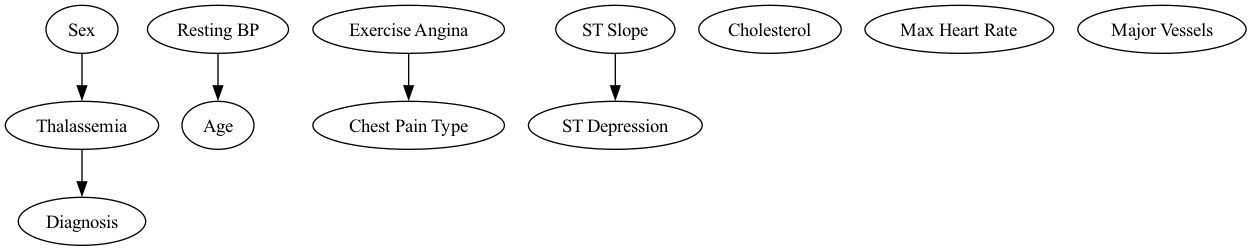

In [6]:
def learn_pc(data: pd.DataFrame, alpha: float = 0.05, max_cond_vars=None):
    pc = PC(data)
    dag: DAG = pc.estimate(
        independence_test="chi_square",
        return_type="dag",
        significance_level=alpha,
        max_cond_vars=max_cond_vars,
    )
    model = DiscreteBayesianNetwork(dag.edges())
    model.add_nodes_from(data.columns)
    return model, dag


model_pc, dag_pc = learn_pc(train_df_disc, alpha=0.05)
print("PC edges:")
for e in model_pc.edges():
    print(e)
show_graphviz(model_pc, outfile="results/bn_pc_graphviz.png")


### HillClimbSearch

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}


  0%|          | 0/1000000 [00:00<?, ?it/s]

HillClimb edges (BDeu score):
('age', 'trestbps')
('thalach', 'slope')
('exang', 'cp')
('slope', 'oldpeak')
('ca', 'age')
('thal', 'num')
('thal', 'sex')
('num', 'exang')
('num', 'thalach')
('num', 'ca')


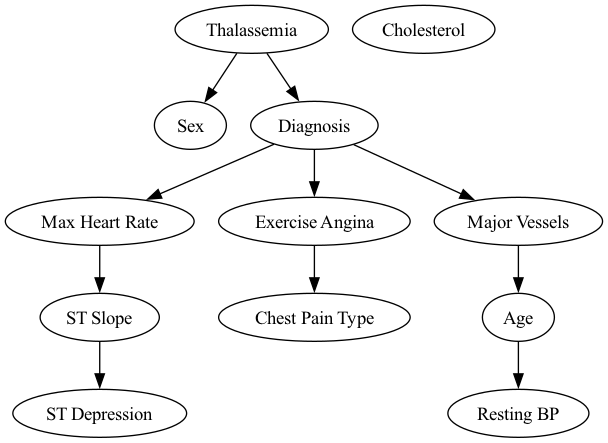

In [7]:
def learn_hc(data: pd.DataFrame, ess: int = 5):
    score = BDeu(data, equivalent_sample_size=ess)
    hc = HillClimbSearch(data)
    model = hc.estimate(scoring_method=score)
    model.add_nodes_from(data.columns)
    return model


model_hc = learn_hc(train_df_disc, ess=5)
print("HillClimb edges (BDeu score):")
for e in model_hc.edges():
    print(e)
show_graphviz(model_hc, outfile="results/bn_hc_graphviz.png")


Custom edges:
('age', 'trestbps')
('age', 'ca')
('age', 'chol')
('age', 'thalach')
('trestbps', 'ca')
('ca', 'num')
('chol', 'trestbps')
('chol', 'ca')
('thalach', 'exang')
('thalach', 'oldpeak')
('sex', 'chol')
('sex', 'cp')
('sex', 'thalach')
('cp', 'exang')
('cp', 'num')
('exang', 'oldpeak')
('oldpeak', 'slope')
('slope', 'num')
('thal', 'num')


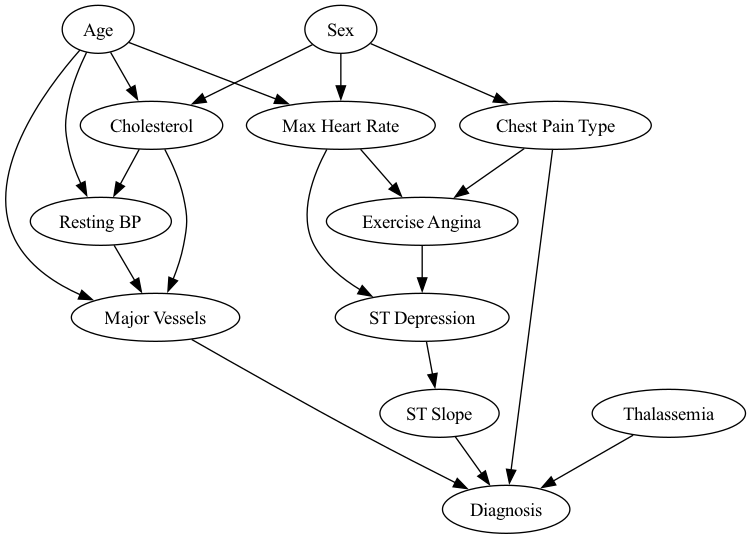

In [8]:
custom_edges = [
    # age
    ("age", "trestbps"),
    ("age", "ca"),
    ("age", "chol"),
    ("age", "thalach"),
    # sex
    ("sex", "chol"),
    ("sex", "cp"),
    ("sex", "thalach"),
    # cp
    ("cp", "exang"),
    ("cp", "num"),
    # trestbps
    ("trestbps", "ca"),
    # chol
    ("chol", "trestbps"),
    ("chol", "ca"),
    # thalach
    ("thalach", "exang"),
    ("thalach", "oldpeak"),
    # exang
    ("exang", "oldpeak"),
    # oldpeak
    ("oldpeak", "slope"),
    # slope
    ("slope", "num"),
    # ca
    ("ca", "num"),
    # thal
    ("thal", "num"),
]

model_custom = DiscreteBayesianNetwork(custom_edges)
model_custom.add_nodes_from(COLUMNS)
print("Custom edges:")
for e in model_custom.edges():
    print(e)
show_graphviz(model_custom, outfile="results/bn_custom_graphviz.png")


## Parameter estimation (CPDs)

In [9]:
def fit_with_bdeu(model_like, data: pd.DataFrame, ess: int = 5):
    edges = list(model_like.edges())
    nodes = list(model_like.nodes())
    bn = DiscreteBayesianNetwork(edges)
    bn.add_nodes_from(nodes)
    bn.fit(
        data,
        estimator=BayesianEstimator,
        prior_type="BDeu",
        equivalent_sample_size=ess,
    )
    return bn


print(f"Fitting CPDs on train split: {len(train_df_disc)} rows")
fitted_models = {
    "pc": fit_with_bdeu(model_pc, train_df_disc),
    "hc": fit_with_bdeu(model_hc, train_df_disc),
    "custom": fit_with_bdeu(model_custom, train_df_disc),
}

for name, m in fitted_models.items():
    print(f"{name} model CPD count: {len(m.get_cpds())}")

print("Custom model CPD for num:")
print(fitted_models["custom"].get_cpds("num"))


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}


Fitting CPDs on train split: 237 rows
pc model CPD count: 9
hc model CPD count: 11
custom model CPD count: 12
Custom model CPD for num:
+--------+--------------------+-----+----------------------+
| ca     | ca(0.0)            | ... | ca(3.0)              |
+--------+--------------------+-----+----------------------+
| cp     | cp(1.0)            | ... | cp(4.0)              |
+--------+--------------------+-----+----------------------+
| slope  | slope(1.0)         | ... | slope(3.0)           |
+--------+--------------------+-----+----------------------+
| thal   | thal(3.0)          | ... | thal(7.0)            |
+--------+--------------------+-----+----------------------+
| num(0) | 0.6613272311212813 | ... | 0.006711409395973155 |
+--------+--------------------+-----+----------------------+
| num(1) | 0.331807780320366  | ... | 0.006711409395973155 |
+--------+--------------------+-----+----------------------+
| num(2) | 0.0022883295194508 | ... | 0.006711409395973155 |
+--------+

## Inference: Clique Tree 


In [10]:
# 确保有完整 CPD（重新拟合一次自定义结构，可改为 model_pc / model_hc）
bn_for_query = fit_with_bdeu(model_custom, train_df_disc, ess=5)

bp = BeliefPropagation(bn_for_query)

queries = [
    {"variables": ["num"], "evidence": {"age": 2, "chol": 2, "exang": 1}},
    {"variables": ["num"], "evidence": {"cp": 3, "thal": 3}},
]

for q in queries:
    bp_res = bp.query(**q)
    print("\nQuery:", q)
    print("BeliefPropagation (Clique Tree):")
    print(bp_res)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}



Query: {'variables': ['num'], 'evidence': {'age': 2, 'chol': 2, 'exang': 1}}
BeliefPropagation (Clique Tree):
+--------+------------+
| num    |   phi(num) |
+========+============+
| num(0) |     0.3167 |
+--------+------------+
| num(1) |     0.2767 |
+--------+------------+
| num(2) |     0.1390 |
+--------+------------+
| num(3) |     0.1879 |
+--------+------------+
| num(4) |     0.0796 |
+--------+------------+

Query: {'variables': ['num'], 'evidence': {'cp': 3, 'thal': 3}}
BeliefPropagation (Clique Tree):
+--------+------------+
| num    |   phi(num) |
+========+============+
| num(0) |     0.7566 |
+--------+------------+
| num(1) |     0.1285 |
+--------+------------+
| num(2) |     0.0383 |
+--------+------------+
| num(3) |     0.0383 |
+--------+------------+
| num(4) |     0.0383 |
+--------+------------+


## 预测任务：判断心脏病是否发作
- 移除 num 列后对特征做 8:2 hold-out 拟合 BN，用 MAP 预测 num 以及 P(num>0) 作为发作风险
- 可选 PC / HC 结构（默认仍使用自定义与专家先验边对关联）
- 举例：输入一个新病人记录，给出 P(num) 向量和 P(心脏病存在)


In [17]:
FEATURE_COLS = [c for c in COLUMNS if c != "num"]


def evaluate_prediction(
    model_like,
    data: pd.DataFrame,
    ess: int = 5,
    test_size: float = 0.2,
    seed: int = 42,
    train_df=None,
    test_df=None,
):
    if train_df is None or test_df is None:
        train_df, test_df = split_train_test(data,
                                             test_size=test_size,
                                             seed=seed)
    bn = fit_with_bdeu(model_like, train_df, ess=ess)
    infer = BeliefPropagation(bn)

    true_num = test_df["num"].tolist()
    pred_num = []
    prob_attack = []

    for _, row in test_df.iterrows():
        evidence = row.drop(labels=["num"]).to_dict()
        q = infer.query(variables=["num"], evidence=evidence)
        probs = pd.Series(q.values, index=q.state_names["num"])
        probs = probs.fillna(0)
        if probs.sum() == 0:
            probs = pd.Series([1.0 / len(probs)] * len(probs),
                              index=probs.index)
        pred_num.append(int(probs.idxmax()))
        prob_attack.append(float(1 - probs.get(0, 0.0)))

    true_attack = [1 if n > 0 else 0 for n in true_num]
    pred_attack = [1 if n > 0 else 0 for n in pred_num]

    acc_num = (pd.Series(pred_num).eq(true_num)).mean()
    acc_attack = (pd.Series(pred_attack).eq(true_attack)).mean()

    print(
        f"Train size: {len(train_df)}, test size: {len(test_df)} (seed={seed})"
    )
    print(f"MAP accuracy (num 0-4): {acc_num:.3f}")
    print(f"Binary accuracy (heart disease vs no disease): {acc_attack:.3f}")
    print(
        f"Mean P(heart disease present): {pd.Series(prob_attack).mean():.3f}")

    return bn, pd.DataFrame({
        "true_num": true_num,
        "pred_num": pred_num,
        "prob_attack": prob_attack,
    })

def query_posterior(
    model,
    variables,
    raw_evidence: dict | None = None,
    binning: str = "custom",
    q: int = 4,
):
    """通用查询：输入变量列表 + 可选原始数值证据（可缺省部分特征）。"""
    if not variables:
        raise ValueError("variables must be a non-empty list")
    raw_evidence = raw_evidence or {}

    feature_cols = (
        FEATURE_COLS
        if "FEATURE_COLS" in globals()
        else [c for c in COLUMNS if c != "num"]
    )

    # 仅对传入的列做分箱，并跳过缺失列
    evidence = {}
    if raw_evidence:
        sample_df = pd.DataFrame([raw_evidence])
        present_cols = [c for c in feature_cols if c in sample_df.columns]
        if present_cols:
            sample_df = sample_df[present_cols]
            if binning == "custom":
                sample_disc = bin_custom(sample_df)
            else:
                if q < 2:
                    raise ValueError("q should be >=2 when using quantile binning")
                sample_disc = sample_df.copy()
                for col in present_cols:
                    sample_disc[col] = pd.qcut(
                        sample_df[col], q=q, labels=False, duplicates="drop"
                    )
            # 只取已分箱且非空的证据
            evidence = sample_disc.iloc[0].dropna().to_dict()

    bp = BeliefPropagation(model)
    qres = bp.query(variables=variables, evidence=evidence or None)

    results = {}
    for var in variables:
        if len(variables) == 1:
            probs = pd.Series(qres.values, index=qres.state_names[var])
        else:
            marginal = qres.marginalize(
                [v for v in variables if v != var], inplace=False
            )
            probs = pd.Series(marginal.values, index=marginal.state_names[var])
        probs = probs.fillna(0)
        if probs.sum() == 0:
            probs = pd.Series([1.0 / len(probs)] * len(probs), index=probs.index)
        results[var] = probs
    return results


## Method Comparison

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb 
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

bn_model = fit_with_bdeu(model_custom, train_df_disc, ess=5)
infer_bn = BeliefPropagation(bn_model)

y_true = test_df_disc["num"].values
y_pred_bn_multi = []
y_pred_bn_binary = []

for _, row in test_df_disc.iterrows():
    # Evidence 是除 'num' 外的所有列
    evidence = row.drop("num").to_dict()
    # 查询 P(num | evidence)
    try:
        q_res = infer_bn.query(variables=["num"], evidence=evidence, show_progress=False)
        probs = q_res.values
        state_map = q_res.state_names["num"] # e.g. [0, 1, 2, 3, 4]
        
        # MAP for Multiclass (取概率最大的状态)
        idx_max = np.argmax(probs)
        pred_class = state_map[idx_max]
        y_pred_bn_multi.append(pred_class)
        
        # Binary Prediction (累加 num > 0 的概率)
        # 假设 state 0 是 "Healthy"
        if 0 in state_map:
            p_healthy = probs[state_map.index(0)]
        else:
            p_healthy = 0.0 # 如果模型认为绝对不可能为0
        
        p_attack = 1.0 - p_healthy
        y_pred_bn_binary.append(1 if p_attack > 0.5 else 0)
        
    except Exception as e:
        # 极少数情况下可能会遇到推理错误，此时默认预测为0
        print(f"Inference error: {e}")
        y_pred_bn_multi.append(0)
        y_pred_bn_binary.append(0)

# 计算 BN 指标
bn_acc_multi = accuracy_score(y_true, y_pred_bn_multi)
# 将真实标签转换为二分类 (0 vs >0)
y_true_binary = [1 if x > 0 else 0 for x in y_true]
bn_acc_binary = accuracy_score(y_true_binary, y_pred_bn_binary)


# 准备 X, y 矩阵
X_train = train_df_disc.drop(columns="num")
y_train = train_df_disc["num"]
X_test = test_df_disc.drop(columns="num")
y_test = test_df_disc["num"]
y_test_bin = (y_test > 0).astype(int)


ml_models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, 
        solver='lbfgs',  # 保持明确的 solver
        n_jobs=-1
    ),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": MultinomialNB(), 
    "K-Nearest Neighbors (K=5)": KNeighborsClassifier(n_neighbors=5),
    "SVM (Linear Kernel)": SVC(kernel="linear", C=1, random_state=42, probability=False),
    "SVM (Poly Kernel)": SVC(kernel="poly", C=1, random_state=42, probability=False),
    "SVM (Sigmoid Kernel)": SVC(kernel="sigmoid", C=1, random_state=42, probability=False),
    "SVM (Rbf Kernel)": SVC(kernel="rbf", C=1, random_state=42, probability=False),

    "XGBoost Classifier": xgb.XGBClassifier(
        eval_metric='mlogloss', 
        random_state=42,
        n_jobs=-1
    )
}
results = []

results.append({
    "Model": "Bayesian Network",
    "Multiclass Acc (0-4)": bn_acc_multi,
    "Binary Acc (0 vs >0)": bn_acc_binary

})

for name, clf in ml_models.items():
    clf.fit(X_train, y_train)
    pred_multi = clf.predict(X_test)
    acc_multi = accuracy_score(y_test, pred_multi)
    pred_bin_derived = [1 if x > 0 else 0 for x in pred_multi]
    acc_bin = accuracy_score(y_test_bin, pred_bin_derived)
    results.append({
        "Model": name,
        "Multiclass Acc (0-4)": acc_multi,
        "Binary Acc (0 vs >0)": acc_bin
    })


df_res = pd.DataFrame(results).set_index("Model")
print("\n=== Updated Model Comparison Results ===")
display(df_res.style.background_gradient(cmap="Blues", subset=["Multiclass Acc (0-4)", "Binary Acc (0 vs >0)"]).format("{:.4f}"))

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}



=== Updated Model Comparison Results ===


,Multiclass Acc (0-4),Binary Acc (0 vs >0)
Model,,
Bayesian Network,0.7000,0.8000
Logistic Regression,0.7167,0.8500
Random Forest,0.6667,0.8167
Naive Bayes,0.6000,0.7500
K-Nearest Neighbors (K=5),0.6167,0.8000
SVM (Linear Kernel),0.6667,0.8500
SVM (Poly Kernel),0.6667,0.8500
SVM (Sigmoid Kernel),0.6667,0.6667
SVM (Rbf Kernel),0.6500,0.8167


In [13]:

def _fmt_val(v):
    if v in (math.inf, -math.inf):
        return "inf" if v > 0 else "-inf"
    if float(v).is_integer():
        return str(int(v))
    return str(v)


def interval_labels(edges, right=True):
    labels = {}
    for i, (lo, hi) in enumerate(zip(edges[:-1], edges[1:])):
        if lo == -math.inf:
            labels[i] = f"< {_fmt_val(hi)}"
        elif hi == math.inf:
            op = ">=" if not right else ">"
            labels[i] = f"{op} {_fmt_val(lo)}"
        else:
            if right:
                labels[i] = f"{_fmt_val(lo)} - {_fmt_val(hi)}"
            else:
                labels[i] = f"[{_fmt_val(lo)}, {_fmt_val(hi)})"
    return labels


BIN_LABELS = {}
for col, cuts in CUSTOM_BINS.items():
    edges = [-math.inf, *cuts, math.inf]
    right = col not in RIGHT_OPEN_COLS
    BIN_LABELS[col] = interval_labels(edges, right=right)

BIN_LABELS.update(
    {
        "sex": {0: "Female", 1: "Male"},
        "cp": {
            1: "Typical Angina",
            2: "Atypical Angina",
            3: "Non-anginal Pain",
            4: "Asymptomatic",
        },
        "exang": {0: "No", 1: "Yes"},
        "slope": {1: "Upsloping", 2: "Flat", 3: "Downsloping"},
        "ca": {0: "0 vessels", 1: "1 vessel", 2: "2 vessels", 3: "3 vessels"},
        "thal": {3: "Normal", 6: "Fixed Defect", 7: "Reversable Defect"},
    }
)


def get_label(col, val):
    if col in BIN_LABELS and val in BIN_LABELS[col]:
        return BIN_LABELS[col][val]
    return str(val)


In [14]:
import pandas as pd
import plotly.graph_objects as go
from pgmpy.inference import BeliefPropagation

def plot_sensitivity_analysis_with_labels(
    bn_model,
    data_df,
    display_names=None,
    bin_labels=None, # <--- New Parameter
    outfile: str = "bn_sensitivity_final.html",
):
    """
    Final Version: Interactive Sensitivity Analysis.
    Displays HUMAN-READABLE labels in tooltips instead of raw bin numbers.
    """
    print("Starting sensitivity analysis (with readable labels)...")
    
    # --- 1. Calculation Logic ---
    infer = BeliefPropagation(bn_model)
    evidence_cols = [c for c in data_df.columns if c != "num"]
    results = {}

    # Calculate Baseline
    try:
        q_baseline = infer.query(variables=["num"], show_progress=False)
        if 0 in q_baseline.state_names["num"]:
            p_healthy_baseline = q_baseline.values[q_baseline.state_names["num"].index(0)]
        else:
            p_healthy_baseline = 0.0
        baseline_p_sick = 1.0 - p_healthy_baseline
    except Exception:
        baseline_p_sick = 0.5 
    
    print(f"Baseline P(Heart Disease) = {baseline_p_sick:.3f}")

    # Loop through features
    for col in evidence_cols:
        min_p = 1.0
        max_p = 0.0
        
        # Store the readable label string instead of just the number
        min_state_label = "N/A"
        max_state_label = "N/A"
        
        possible_values = sorted(data_df[col].unique())
        valid_calc = False

        for val in possible_values:
            try:
                q_res = infer.query(
                    variables=["num"], evidence={col: val}, show_progress=False
                )
                
                if 0 in q_res.state_names["num"]:
                    idx_0 = q_res.state_names["num"].index(0)
                    p_healthy = q_res.values[idx_0]
                else:
                    p_healthy = 0.0
                
                p_sick = 1.0 - p_healthy
                
                # Retrieve readable label using helper
                current_label = get_label(col, val) if bin_labels else str(val)

                # Track Max
                if p_sick > max_p:
                    max_p = p_sick
                    max_state_label = current_label # <--- Store Label
                
                # Track Min
                if p_sick < min_p:
                    min_p = p_sick
                    min_state_label = current_label # <--- Store Label

                valid_calc = True
            except Exception:
                continue
        
        if not valid_calc:
            results[col] = (baseline_p_sick, baseline_p_sick, "N/A", "N/A")
        else:
            results[col] = (max_p, min_p, max_state_label, min_state_label)

    # --- 2. Data Preparation ---
    df_results = pd.DataFrame.from_dict(
        results, orient="index", columns=["Max P", "Min P", "Max Label", "Min Label"]
    )
    df_results["Range"] = df_results["Max P"] - df_results["Min P"]
    df_results = df_results.sort_values(by="Range", ascending=True)

    if display_names:
        labels = [display_names.get(col, col) for col in df_results.index]
    else:
        labels = df_results.index.tolist()

    # --- 3. Plotting ---
    color_max = "#e74c3c"
    color_min = "#3498db"
    color_bar = "#bdc3c7"
    color_base = "#555555"

    fig = go.Figure()

    # A. Connecting Bar
    for i, (idx, row) in enumerate(df_results.iterrows()):
        fig.add_trace(go.Scatter(
            x=[row["Min P"], row["Max P"]],
            y=[labels[i], labels[i]],
            mode='lines',
            line=dict(color=color_bar, width=12),
            showlegend=False,
            hoverinfo='skip'
        ))

    # B. Min Risk Points
    fig.add_trace(go.Scatter(
        x=df_results["Min P"],
        y=labels,
        mode='markers+text',
        name='Min Risk Condition',
        marker=dict(color=color_min, size=16, line=dict(width=1, color='white')),
        text=[f'{x:.3f}' for x in df_results["Min P"]],
        textposition="middle left",
        
        # Pass Readable Label to CustomData
        customdata=df_results["Min Label"],
        
        hovertemplate=(
            "<b>Feature: %{y}</b><br>" +
            "Condition: <b>%{customdata}</b><br>" + # Displays: "Age < 45" or "Female"
            "Risk Probability: %{x:.3f}" +
            "<extra></extra>"
        )
    ))

    # C. Max Risk Points
    fig.add_trace(go.Scatter(
        x=df_results["Max P"],
        y=labels,
        mode='markers+text',
        name='Max Risk Condition',
        marker=dict(color=color_max, size=16, line=dict(width=1, color='white')),
        text=[f'{x:.3f}' for x in df_results["Max P"]],
        textposition="middle right",
        
        # Pass Readable Label to CustomData
        customdata=df_results["Max Label"],
        
        hovertemplate=(
            "<b>Feature: %{y}</b><br>" +
            "Condition: <b>%{customdata}</b><br>" + # Displays: "Asymptomatic" or "High BP"
            "Risk Probability: %{x:.3f}" +
            "<extra></extra>"
        )
    ))

    # D. Baseline
    fig.add_vline(
        x=baseline_p_sick,
        line_width=2,
        line_dash="dash",
        line_color=color_base,
        annotation_text=f"Baseline: {baseline_p_sick:.3f}", 
        annotation_position="top right"
    )

    # E. Layout
    fig.update_layout(
        title={
            'text': 'Sensitivity Analysis: High vs Low Risk Conditions',
            'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top',
            'font': dict(size=20, color='black', family="Arial")
        },
        xaxis=dict(
            title='Probability of Heart Disease P(num > 0)',
            range=[max(0, df_results["Min P"].min() - 0.05), min(1.0, df_results["Max P"].max() + 0.05)],
            showgrid=False,
            zeroline=False
        ),
        yaxis=dict(
            showgrid=False,
            tickfont=dict(size=14, color='black')
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        legend=dict(orientation="h", yanchor="bottom", y=-0.15, xanchor="center", x=0.5),
        margin=dict(l=20, r=20, t=80, b=80),
        height=700,
        hoverlabel=dict(bgcolor="white", font_size=14, font_family="Arial")
    )

    fig.write_html(outfile)
    print(f"Final Interactive plot saved to {outfile}")
    fig.show()
    
    return df_results


_ = plot_sensitivity_analysis_with_labels(
    bn_model,
    train_df_disc,
    display_names=DISPLAY_NAMES,
    bin_labels=BIN_LABELS, # <--- Crucial Step
    outfile="results/bn_sensitivity_final.html"
)

Starting sensitivity analysis (with readable labels)...
Baseline P(Heart Disease) = 0.535
Final Interactive plot saved to results/bn_sensitivity_final.html


In [27]:

example_patient = {
            # "age":69,
            # "cp": 4,
            # "trestbps": 140,
            # "chol": 243,
            # "thalach": 160,
            # "exang": 0,
            # "oldpeak": 1.2,
            # "slope": 2,
            # "ca": 3,
            # "thal": 3,
        }

posterior = query_posterior(
            bn_model,
            variables=["num"],
            raw_evidence=example_patient,
            binning=cfg.binning,
            q=cfg.q,
        )
posterior



{'num': 0    0.464605
 1    0.230573
 2    0.106645
 3    0.136566
 4    0.061612
 dtype: float64}

In [30]:
from pathlib import Path

import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
from pgmpy.inference import BeliefPropagation


def render_clique_tree(
    model,
    display_names: dict | None = None,
    outfile: str = "results/clique_tree.png",
    prog: str = "dot",
):
    """
    Render the clique/junction tree of a Bayesian Network with Graphviz.

    Args:
        model: Trained pgmpy Bayesian Network.
        display_names: Optional mapping var -> readable label.
        outfile: Output image path.
        prog: Graphviz layout engine (e.g., "dot", "neato").

    Returns:
        The output file path.
    """
    bp = BeliefPropagation(model)
    jt = bp.junction_tree.copy()

    # Set Graphviz labels without changing node keys (ClusterGraph requires tuple nodes).
    label_attr = {}
    for n in jt.nodes():
        vars_in_clique = sorted(list(n))
        label_attr[n] = "\\n".join(
            (display_names.get(v, v) if display_names else v) for v in vars_in_clique
        )
    nx.set_node_attributes(jt, label_attr, "label")

    A = to_agraph(jt)
    A.layout(prog=prog)
    Path(outfile).parent.mkdir(parents=True, exist_ok=True)
    A.draw(outfile)
    return outfile

path = render_clique_tree(bn_model, outfile="results/clique_tree.png", prog="dot")
print("Saved:", path)

Saved: results/clique_tree.png
